In [1]:
from visualizer import calibration
import visual

from PyQt5 import QtCore
import tifffile
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import zarr
from skimage.registration import phase_cross_correlation
import cv2 as cv
from skimage import io
from skimage.morphology import skeletonize
from skan import Skeleton
import scipy.ndimage as ndi
import cupy as cp 
import waveorder as wo
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask
import cv2 as cv
%gui qt 
%matplotlib inline
plt.style.use('dark_background')


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


c:\ProgramData\Anaconda3\envs\m25-py39\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [3]:
### Enter the filepath for the data directory
main_dir =r'F:\DATA\20220507_M25_ZW495_9'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_pcc = os.path.join(offset_dir,"offsets_pcc.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

if os.path.exists(offsets_file_pcc):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets_pcc = np.loadtxt(file_name, delimiter=",")
## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

In [4]:
# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

### LOAD DATASET

In [5]:
### For preexisting tiff saved datasets
filename = 'aligned_stack.zarr'
filepath_save = os.path.join(processed_files,filename)
zarr_stack = zarr.load(filepath_save)
#Compensate center plane
zarr_stack[:,12,:,:]=zarr_stack[:,12,:,:]*1.23077

In [5]:
#Reading RAW 1 plane
folder = main_dirs[12]
file_extension = folder + '/' + '*.raw'
file_names = sorted(glob(file_extension),key=alphanumeric_key)
raw_ds = calibration.dask_raw_ds(folder,px_depth='uint16', width=608,height=608)
dask_raw_ds = da.stack(raw_ds,axis=1)
dask_raw_ds.shape

(1, 600, 608, 608)

In [8]:
#Cropping stack for testing
crop_stack = zarr_stack[60:200,12,:,:]
# crop_stack = dask_raw_ds[:,60:200,:,:]
viewer.add_image(crop_stack)
crop_stack_gauss = ndi.gaussian_filter(crop_stack,sigma=5)
viewer.add_image(crop_stack_gauss)

<Image layer 'crop_stack_gauss' at 0x29001729520>

663


<Image layer 'binary_stack [1]' at 0x29019168ac0>

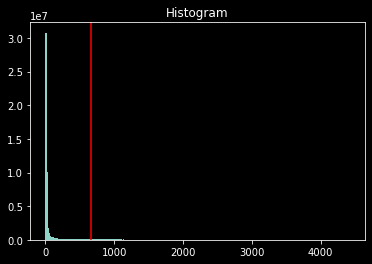

In [12]:
from skimage.filters import threshold_otsu, threshold_yen

thresh_otsu = threshold_otsu(crop_stack_gauss)
#Ended up tunning the threshold to a higher value
binary_stack = crop_stack_gauss > 660
print(thresh_otsu)
plt.hist(crop_stack_gauss.ravel(), bins=256)
plt.title('Histogram')
plt.axvline(thresh_otsu, color='r')
viewer.add_image(binary_stack)

In [21]:
# binary_stack2 =ndi.binary_opening(binary_stack,5)
binary_stack_filled = ndi.binary_fill_holes(binary_stack)
binary_stack_filled = np.expand_dims(binary_stack_filled,axis=0)

print(binary_stack_filled.shape)
# wo.image_stack_viewer(binary_stack_filled)
viewer.add_image(binary_stack_filled)

(1, 140, 608, 608)


<Image layer 'binary_stack_filled [2]' at 0x29024e66580>

(1, 1135, 2)
0


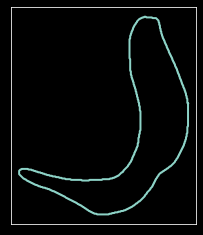

In [30]:
from skimage.measure import find_contours
i=14
contours=find_contours(binary_stack_filled[0,i],0.3)
print(np.array(contours).shape)
# Display the image and plot all contours found
fig, ax = plt.subplots()
# ax.imshow(contours_stack[i], interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    print(n)
    ax.plot(contour[:, 0], contour[:, 1], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [31]:
binary_stack_filled[0,2].shape
print(contours)
contour= np.array(contours)
print(contour.shape)
# print(contour)
print(contour[:,1].shape)
print(contour[:,0].shape)
print(contour[0,0,1])


[array([[344.7, 251. ],
       [344.7, 250. ],
       [344.7, 249. ],
       ...,
       [343.7, 252. ],
       [344. , 251.7],
       [344.7, 251. ]])]
(1, 1135, 2)
(1, 2)
(1, 2)
251.0


In [33]:
t,z,y,x =binary_stack_filled.shape
print(binary_stack_filled.shape)
contour_coords =[]
for i in range(t):
    contours = find_contours(binary_stack_filled[i,0],0.8)
    contours= np.array(contours)
    # print(contours.shape)
    for n in range(contours.shape[1]):
        contour_coords.append([i,contours[0,n,0], contours[0,n,1]])

    # contour_coords.append(np.array(contour))
    # for k in range(contour.shape[0]):
    #     contour_coords[i,:,:] = np.array([0,i,contour[k,0],contour[k,1]])
contour_coords=np.array(contour_coords)
viewer.add_points(contour_coords,edge_color='pink')

(1, 140, 608, 608)


<Points layer 'contour_coords' at 0x29026dae3a0>

In [34]:
print(contour_coords[0,1])
print(contour_coords.shape)
# contour_coords[1]

357.2
(1009, 3)


(1, 140, 608, 608)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(-0.5, 607.5, 607.5, -0.5)

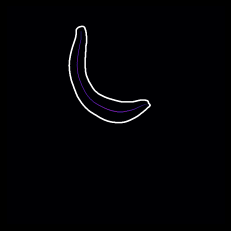

In [197]:
from skimage.morphology import medial_axis
print(binary_stack_filled.shape)
binary_stack_filled3d = np.squeeze(binary_stack_filled)
skel, distance = medial_axis(binary_stack_filled3d[1], return_distance=True)
# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel
print(dist_on_skel)
plt.imshow(dist_on_skel, cmap='magma')
plt.contour(binary_stack_filled3d[1], [0.5], colors='w')
plt.axis('off')

In [146]:
#countour the stack
print(contour_coords[1].shape)
contour_coords.shape


(1, 1011, 2)


ValueError: operands could not be broadcast together with shapes (1,1009,2) (1009,) 

In [129]:
# perform skeletonization
skeleton =np.array([skeletonize(binary_stack_filled3d[i]) for i in range(binary_stack_filled3d.shape[0])])
print(skeleton.shape)
viewer.add_image(skeleton, colormap='magenta', blending='additive')

(140, 608, 608)


<Image layer 'skeleton [1]' at 0x25736ec2730>

In [130]:
from skan import Skeleton
sk_skeleton =[Skeleton(skeleton[i]) for i in range(skeleton.shape[0])]

In [131]:
print((sk_skeleton[1].coordinates))
print(sk_skeleton[10].path_lengths())
print(sk_skeleton[10].distances)

[[  0.   0.]
 [ 68. 207.]
 [ 69. 207.]
 [ 70. 206.]
 [ 71. 206.]
 [ 72. 206.]
 [ 73. 206.]
 [ 74. 206.]
 [ 75. 205.]
 [ 76. 205.]
 [ 77. 205.]
 [ 78. 205.]
 [ 79. 205.]
 [ 80. 205.]
 [ 81. 206.]
 [ 82. 206.]
 [ 83. 206.]
 [ 84. 206.]
 [ 85. 206.]
 [ 86. 206.]
 [ 87. 206.]
 [ 88. 206.]
 [ 89. 206.]
 [ 90. 206.]
 [ 91. 206.]
 [ 92. 206.]
 [ 93. 206.]
 [ 94. 206.]
 [ 95. 205.]
 [ 96. 205.]
 [ 97. 205.]
 [ 98. 205.]
 [ 99. 205.]
 [100. 205.]
 [101. 205.]
 [102. 205.]
 [103. 205.]
 [104. 205.]
 [105. 204.]
 [106. 204.]
 [107. 204.]
 [108. 204.]
 [109. 204.]
 [110. 204.]
 [111. 203.]
 [112. 203.]
 [113. 203.]
 [114. 203.]
 [115. 202.]
 [116. 202.]
 [117. 202.]
 [118. 202.]
 [119. 202.]
 [120. 202.]
 [121. 202.]
 [122. 201.]
 [123. 201.]
 [124. 201.]
 [125. 201.]
 [126. 200.]
 [127. 200.]
 [128. 200.]
 [129. 200.]
 [130. 200.]
 [131. 200.]
 [132. 199.]
 [133. 199.]
 [134. 199.]
 [135. 199.]
 [136. 199.]
 [137. 199.]
 [138. 199.]
 [139. 199.]
 [140. 198.]
 [141. 198.]
 [142. 198.]
 [143. 198.]

In [132]:
# Finding the points where we have start/ends
end_points =[]
for k in range(len(sk_skeleton)):
    for i, val in enumerate(sk_skeleton[k].coordinates[sk_skeleton[k].degrees == 1]):
      end_points.append([k,val[0],val[1]])

np_endPoint = np.array(end_points)
print(np_endPoint.shape)
viewer.add_points(np_endPoint, face_color='cornflowerblue')


(316, 3)


<Points layer 'np_endPoint [1]' at 0x2573a289880>

In [306]:
#Borrwing from WormPose
# https://github.com/iteal/wormpose/blob/main/wormpose/pose/centerline.py
from scipy.interpolate import interp1d
def interpolate_skeleton(skeleton: np.ndarray, new_dims: int) -> np.ndarray:
    """
    Interpolates a worm skeleton to have a different number of points
    """
    new_pos_dim = []
    for dim in range(skeleton.shape[1]):
        y = skeleton[:, dim]
        x = np.arange(y.size)
        if np.any(np.isnan(y)):
            new_pos_dim.append([np.nan] * (new_dims + 1))
        else:
            # Interpolate the data using a cubic spline to "new_length" samples
            new_length = new_dims + 1
            new_x = np.linspace(x.min(), x.max(), new_length)
            new_y = interp1d(x, y, kind="cubic")(new_x)
            new_pos_dim.append(new_y)
    new_pos = np.vstack(new_pos_dim).T
    return new_pos

In [304]:
print(contour_coords.shape)
print(contour_coords[0])


(160826, 3)
[  0.  325.2 320. ]


In [362]:
#Interpolate Contour
contour_interp=[]
c,t,y,x = crop_stack.shape
for k in range(t):
    contours = find_contours(binary_stack_filled[0,k],0.8)
    countours=np.array(contours)
    inter_cont_coord = interpolate_skeleton(contours[0],50)
    for c_num in range(inter_cont_coord.shape[0]):
        contour_interp.append([k,inter_cont_coord[c_num,0],inter_cont_coord[c_num,1]])
contour_interp=np.array(contour_interp)
viewer.add_points(contour_interp, face_color='cornflowerblue')

TypeError: Only integer types are supported for Labels layers, but data contains float64.

In [345]:
contour_interp[:,1:]

array([[320.        , 325.2       ],
       [300.63843386, 324.11970578],
       [283.27337642, 321.3858939 ],
       ...,
       [316.95141328, 446.24143119],
       [299.18647098, 453.02442191],
       [280.        , 457.2       ]])

In [376]:
i=3
bbbox_cont= create_skeleton_box(contour_interp[i,1:], contour_interp[i+1,1:],side='center',width=30)
min_val = bbbox_cont.min(axis=0)
max_val = bbbox_cont.max(axis=0)
tl = np.array([min_val[0], min_val[1]])
br = np.array([max_val[0], max_val[1]])
img_box = np.round(np.array([tl, br])).astype(int)
z = np.zeros((2,2)).astype(int)
img_box = np.hstack((z,img_box)).astype(int)

viewer.add_shapes(bbbox_cont)

<Shapes layer 'bbbox_cont' at 0x257428bfa90>

In [374]:
bbbox_cont.shape

NameError: name 'bbbox_cont' is not defined

In [360]:
select_coords =[]
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,50)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
select_coords=np.array(select_coords)
viewer.add_points(select_coords, face_color='cornflowerblue')

ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [321]:
"""
Refresh on vector calc
https://stackoverflow.com/questions/7469959/given-2-points-how-do-i-draw-a-line-at-a-right-angle-to-the-line-formed-by-the-t/7470098#7470098
The matrix representation of 2D transformation:
x' = xcos(t) - ysin(t)
y' = xsin(t)  - ycost(t)

so if t =90 deg then 
x'=-y
y'= x

then normals to line segment would be:
(-dy,dx)(dy,-dx)

"""
width = 100
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect = np.array(
    [bot_l, top_l, top_r, bot_r]
)


NameError: name 'coord_b' is not defined

In [470]:
#Plotting left and right boxes
width = 50
skel_perp = np.empty((2,), dtype=np.float32)

perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
# Take the magnitude to get the length of the vector 
norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

#Normal to skeleton
skel_perp[0] = (perp_line[0] / norm) * (width / 2)
skel_perp[1] = (perp_line[1] / norm) * (width / 2)
# skel_perp[1] = (perp_line[1] / norm) 

##Box origin is 'lower' instead of upper
bot_l = coord_a + skel_perp
top_l = coord_b + skel_perp
top_r = coord_b - skel_perp # 
bot_r = coord_a - skel_perp # 

bbox_rect_left = np.array(
    [coord_a, coord_b, top_l, bot_l]
)

bbox_rect_right = np.array(
    [coord_a, coord_b, top_r, bot_r]
)

In [352]:
#Make the skeleton Points
select_coords =[]
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,50)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
select_coords=np.array(select_coords)
viewer.add_points(select_coords, face_color='cornflowerblue')

ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [351]:
def create_skeleton_box(coord_a,coord_b,side='center',width='100'):
    """
    
    Refresh on vector calc
    https://stackoverflow.com/questions/7469959/given-2-points-how-do-i-draw-a-line-at-a-right-angle-to-the-line-formed-by-the-t/7470098#7470098
    The matrix representation of 2D transformation:
    x' = xcos(t) - ysin(t)
    y' = xsin(t)  - ycost(t)

    so if t =90 deg then 
    x'=-y
    y'= x

    then normals to line segment would be:
    (-dy,dx)(dy,-dx)

    """
    skeleton_norm = np.empty((2,), dtype=np.float32)

    perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
    # Take the magnitude to get the length of the vector 
    norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

    skeleton_norm[0] = (perp_line[0] / norm) * (width / 2)
    skeleton_norm[1] = (perp_line[1] / norm) * (width / 2)

    ##Box origin is 'lower' instead of upper
    bot_l = coord_a + skeleton_norm
    top_l = coord_b + skeleton_norm
    top_r = coord_b - skeleton_norm # 
    bot_r = coord_a - skeleton_norm # 

    if side == 'L':
        bbox_rect_left = np.array(
            [coord_a, coord_b, top_l, bot_l]
        )
        return bbox_rect_left
    elif side == 'R':
        bbox_rect_right = np.array(
            [coord_a, coord_b, top_r, bot_r]
        )
        return bbox_rect_right
    elif side == 'LR':
        bbox_rect_left =[coord_a, coord_b, top_l, bot_l]
        bbox_rect_right =[coord_a, coord_b, top_r, bot_r]
        return np.array([bbox_rect_left, bbox_rect_right])
    elif side =='center':
        bbox_rect = np.array(
            [bot_l, top_l, top_r, bot_r]
        )
        return bbox_rect



In [334]:
i=0
left_box, right_box  = create_skeleton_box(interp_coord[i], interp_coord[i+1],side='LR',width=50)
a = np.array([left_box , right_box])
print(a)
print(left_box.shape)
z = np.zeros((4,2))
left_box = np.hstack((z,left_box))
left_box[:,1]= 1
print(z)
print(left_box.shape)
print(left_box)

[[[ 69.         209.        ]
  [137.8        197.01114666]
  [146.3834837  246.26887524]
  [ 77.5834837  258.25772858]]

 [[ 69.         209.        ]
  [137.8        197.01114666]
  [129.2165163  147.75341808]
  [ 60.4165163  159.74227142]]]
(4, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(4, 4)
[[  0.           1.          69.         209.        ]
 [  0.           1.         137.8        197.01114666]
 [  0.           1.         146.3834837  246.26887524]
 [  0.           1.          77.5834837  258.25772858]]


In [140]:
k=0
layer_boxes = []
coords =sk_skeleton[k].path_coordinates(0)
interp_coord = interpolate_skeleton(coords,50)
for i in range(interp_coord.shape[0]-1):
    left_box, right_box  = create_skeleton_box(interp_coord[i], interp_coord[i+1],side='LR',width=50)
    layer_boxes.append([left_box , right_box])
layer_boxes = np.array(layer_boxes)
print(layer_boxes.shape)

# viewer.add_shapes(layer_boxes[1,0]  ,edge_color='blue')


(50, 2, 4, 2)


In [141]:
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0,:,:]  ,face_color='blue') # Left boxes
viewer.add_shapes(layer_boxes[:,1,:,:]  ,face_color='red') # Right boxes

<Shapes layer 'Shapes [1]' at 0x25737033eb0>

In [46]:
interp_coord.shape[0]

51

In [311]:
c_num = 1
left_box, right_box  = create_skeleton_box(interp_coord[c_num], interp_coord[c_num+1],side='LR',width=50)
print(left_box)
left_box.shape

[[137.8        197.01114666]
 [206.6        199.11191896]
 [205.07398722 249.08862641]
 [136.27398722 246.98785412]]


(4, 2)

In [142]:
##Combining both coordinate interpolation with boxes
select_coords =[]
layer_boxes = []
n_interpol = 15
for k in range(len(sk_skeleton)):
    coords =sk_skeleton[k].path_coordinates(0)
    interp_coord = interpolate_skeleton(coords,n_interpol)
    for c_num in range(interp_coord.shape[0]):
        select_coords.append([k,interp_coord[c_num,0],interp_coord[c_num,1]])
        if c_num<(interp_coord.shape[0]-1):
            left_box, right_box  = create_skeleton_box(interp_coord[c_num], interp_coord[c_num+1],side='LR',width=50)
            two_column = np.zeros((4,2))
            left_box = np.hstack((two_column,left_box))
            right_box = np.hstack((two_column,right_box))
            left_box[:,1]= k
            right_box[:,1]=k
            layer_boxes.append([left_box , right_box])
select_coords=np.array(select_coords)
layer_boxes = np.array(layer_boxes)
#Plot skeleton interpolation points
viewer.add_points(select_coords, face_color='cornflowerblue')
##Plot the L and R boxes
viewer.add_shapes(layer_boxes[:,0]  ,face_color='blue') # Left boxes
viewer.add_shapes(layer_boxes[:,1],face_color='red') # Right boxes


ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

In [357]:
## Retreiving measurements from Boxes
left_box_stack = layer_boxes[:,0]
left_box_stack[0,:].min(axis=0)


array([  0.        ,   0.        ,  69.        , 204.99248348])

In [363]:
print(layer_boxes[0,1:])
print(layer_boxes[0,1,0:,2:])

[[[  0.           0.          69.         209.        ]
  [  0.           0.          92.13333333 204.99248348]
  [  0.           0.          83.59867204 155.72627102]
  [  0.           0.          60.46533871 159.73378754]]]
[[ 69.         209.        ]
 [ 92.13333333 204.99248348]
 [ 83.59867204 155.72627102]
 [ 60.46533871 159.73378754]]


In [ ]:
def make_box(roi_box,image):
    num_boxes = roi_box.shape
    for i in num_boxes:
        min_val = bbox_rect_right.min(axis=0)
        max_val = bbox_rect_right.max(axis=0)
        tl = np.array([min_val[0], min_val[1]])
        br = np.array([max_val[0], max_val[1]])
        box = np.round(np.array([tl, br])).astype(int)

In [385]:
layer_boxes.shape

(2100, 2, 4, 4)

In [383]:
bbox_rect_right= layer_boxes[0,1,0:,2:]
min_val = bbox_rect_right.min(axis=0)
max_val = bbox_rect_right.max(axis=0)
tl = np.array([min_val[0], min_val[1]])
br = np.array([max_val[0], max_val[1]])
box = np.round(np.array([tl, br])).astype(int)
print(bbox_rect_right)
print(tl)
print(br)
print(box)
print(box[1,0])

[[ 69.         209.        ]
 [ 92.13333333 204.99248348]
 [ 83.59867204 155.72627102]
 [ 60.46533871 159.73378754]]
[ 60.46533871 155.72627102]
[ 92.13333333 209.        ]
[[ 60 156]
 [ 92 209]]
92


In [505]:
# import analysis_utils as au

img = crop_stack[:,:,box[0,0]:box[1,0],box[0,1]:box[1,1]]
roi_mean = img.mean()
roi_max = img.max()
print(roi_mean.compute(),roi_max.compute())

1248.9526542324247 4304


In [381]:
## Example to show how shapes are stored
a =np.array(viewer.layers['Shapes [2]'].data)
a0= viewer.layers['Shapes [2]'].data[0]
print(a.shape)
print(a)
# print(a0[:,2], a0[:,1])


(2, 4, 4)
[[[  0.           0.         330.0198765   69.53220533]
  [  0.           0.         330.0198765  202.44669227]
  [  0.           0.         437.24500882 202.44669227]
  [  0.           0.         437.24500882  69.53220533]]

 [[  0.           0.         386.98322805 287.33325535]
  [  0.           0.         386.98322805 443.70323998]
  [  0.           0.         469.63593421 443.70323998]
  [  0.           0.         469.63593421 287.33325535]]]
[330.0198765  330.0198765  437.24500882 437.24500882] [0. 0. 0. 0.]


### PLAYGROUND

In [ ]:
## Attempt to get the coordinates of the skeleton however they are already sorted so only way to do this is with interpolation
# select_coords =[]
# path_length = []
# id =[]
# for k in range(len(sk_skeleton)):
#     length = sk_skeleton[k].path_lengths()
#     # path_length.append(length)
#     for index,item in enumerate(sk_skeleton[k].coordinates):
#         if index%(int(length[0]/5)) ==0:
#             # id.append(index)
#             select_coords.append([k,item[0],item[1]])
# # select_coords = np.array(select_coords)
# print(id)
# print(path_length)

In [ ]:
from skan import summarize
#Attempting to plot multiple points in skeleton
i=0
branch = summarize(sk_skeleton[i])
branch.head()
img_t =crop_stack[:,0,:,:]
img_t =np.squeeze(img_t)
# branch.hist(column='branch-distance', by='branch-type', bins=100);
draw.overlay_euclidean_skeleton_2d(img_t, branch,
                                   skeleton_color_source='branch-type');

In [ ]:
from scipy.ndimage import distance_transform_edt
sk_skeleton[0].coo
distance_transform_edt()

In [402]:
binary_stack_filled_1=np.squeeze(binary_stack_filled)
print(binary_stack_filled_1.shape)

(200, 608, 608)


In [416]:
from skimage.measure import label, regionprops_table

properties = regionprops_table(
    binary_stack_filled_1[0].astype(np.uint8), properties=('label', 'bbox', 'perimeter', 'area')
)

#Addinc circularity to the table
properties['circularity'] = circularity(
    properties['perimeter'], properties['area']
)

bbox_rects = make_bbox([properties[f'bbox-{i}'] for i in range(4)])

# specify the display parameters for the text
text_parameters = {
    'string': 'label: {label}\ncirc: {circularity:.2f}',
    'size': 12,
    'color': 'green',
    'anchor': 'upper_left',
    'translation': [-3, 0],
}

shapes_layer = viewer.add_shapes(
    bbox_rects,
    face_color='transparent',
    edge_color='green',
    properties=properties,
    text=text_parameters,
    name='bounding box',
)

In [414]:
def make_bbox(coord_a,coord_b,width):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    # preallocates some internal data structures
    skel_perp = np.empty((2,), dtype=np.float32)

    perp_line = [-(coord_b[1]-coord_a[1]), coord_b[0]-coord_a[0]]
    norm = np.sqrt(perp_line[0]*perp_line[0]+perp_line[1]*perp_line[1])

    skel_perp[0] = (perp_line[0] / norm) * (width / 2)
    skel_perp[1] = (perp_line[1] / norm) * (width / 2)

    minr = coord_a + skel_perp
    minc = coord_b + skel_perp
    maxr = coord_b - skel_perp
    maxc = coord_a - skel_perp

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

In [391]:
viewer.add_points(select_coords, face_color='cornflowerblue')

<Points layer 'select_coords' at 0x12431f1b910>

In [386]:
import pims
import trackpy as tp

In [ ]:
features = tp.locate(np_stack[12], diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))
print('Features found: {0}'.format(len(features)))
tp.subpx_bias(features)
print('Features found: {0}'.format(len(features)))
features.head()

In [ ]:
test =tp.annotate3d(features,np_stack[1],color=None)
test3 =np.array(test[:,np.newaxis,:,:,:])
test3 = np.swapaxes(test3,1,4)
test3 = np.squeeze(test3)

wo.image_stack_viewer(np.clip(test3,0,0.5),colormap='viridis')

In [ ]:
volume = tp.batch(np_stack, diameter=(7,7,7), threshold =84,minmass=11000, separation= (3,1,1))


In [ ]:
linked = tp.link_df(volume, 2.5, pos_columns=['xum', 'yum', 'zum'])
msd3D = tp.emsd(linked, mpp=1, fps=40, max_lagtime=20,
                pos_columns=['xum', 'yum', 'zum'])
ax = msd3D.plot(style='o', label='MSD in 3D')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
ax.set_xlabel('lag time $t$')
# ax.set_xlim(0, 16)
# ax.set_ylim(0, 20)
ax.legend(loc='upper left');

<Image layer 'dask_raw_ds [1]' at 0x12432fa3760>

In [ ]:
data = linked.loc[:,['particle','frame','z','y','x']]
data = data.dropna(axis=0)
data= data.to_numpy()
print(data)

properties = linked.loc[:,['mass', 'size_z', 'size_y', 'size_x','signal','raw_mass','ep_z','ep_y','ep_x']]

In [ ]:
viewer.add_points(data[:,1:], size=1,name='particles',face_color='white',
edge_color= '#ff55ff', scale=[1,z_scale,1,1])

In [ ]:
viewer.add_tracks(data, scale=[z_scale,1,1])